In [1]:
%matplotlib notebook
from neuron_sim_utils import *
from plot_utils import *
from collections import defaultdict

In [2]:
cell = CA1_Pyr()

In [ ]:
plot_mech_param_distribution(cell, 'pas', 'g')

In [ ]:
plot_sum_mech_param_distribution(cell, (('nax', 'gbar'), ('nas', 'gbar')))

In [ ]:
plot_sum_mech_param_distribution(cell, (('kap', 'gkabar'), ('kad', 'gkabar')))

In [ ]:
plot_mech_param_distribution(cell, 'h', 'ghbar')

In [ ]:
pprint.pprint(cell.mech_dict)

In [3]:
sim = QuickSim()
sim.tstop = 250.

In [ ]:
help(sim.append_rec)

In [4]:
sim.append_rec(cell, cell.soma[0], loc=0.5, description='Soma Vm')

In [ ]:
sim.run()
sim.plot()

In [ ]:
help(sim.append_stim)

In [5]:
sim.append_stim(cell, cell.soma[0], 0.5, 0.25, 250., 100., description='Soma Step Current')

In [6]:
spike_output_vec = h.Vector()
cell.spike_detector.record(spike_output_vec)

0.0

Simulation runtime:  6.0777599811553955  sec


<IPython.core.display.Javascript object>


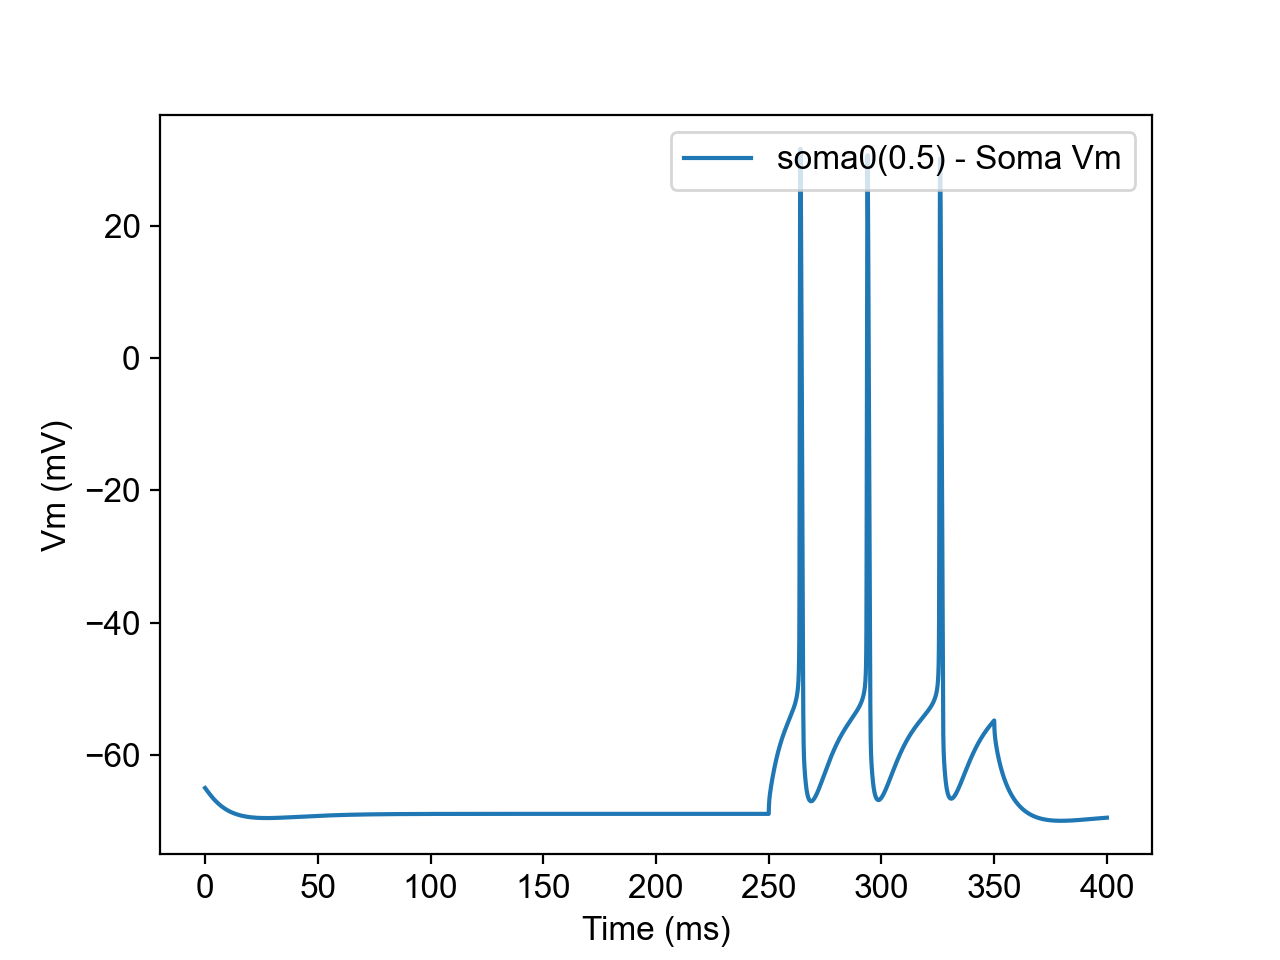

In [7]:
sim.tstop = 400.
sim.run()
sim.plot()

In [ ]:
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

In [8]:
trunk_bifurcation = [trunk for trunk in cell.trunk if cell.is_bifurcation(trunk, 'trunk')]
if trunk_bifurcation:
    trunk_branches = [branch for branch in trunk_bifurcation[0].children if branch.type == 'trunk']
    # get where the thickest trunk branch gives rise to the tuft
    trunk = max(trunk_branches, key=lambda node: node.sec(0.).diam)
    trunk = next((node for node in cell.trunk if cell.node_in_subtree(trunk, node) and 'tuft' in (child.type
                                                                                    for child in node.children)))
else:
    trunk_bifurcation = [node for node in cell.trunk if 'tuft' in (child.type for child in node.children)]
    trunk = trunk_bifurcation[0]
    
sim.append_rec(cell, trunk, 1., description='Dendritic trunk')

In [ ]:
help(cell.get_distance_to_node)

In [ ]:
distance = cell.get_distance_to_node(cell.soma[0], trunk, 1.)
print('Recording in dendritic trunk is %i um from the soma' % distance)

In [ ]:
sim.run()
sim.plot()
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

In [ ]:
rec_file_name = '20201020_CA1Sim_0.hdf5'
if os.path.isfile(data_dir + '/' + rec_file_name):
    os.remove(data_dir + '/' + rec_file_name)

sim.export_to_file(rec_file_name)

In [ ]:
help(sim.modify_stim)

In [ ]:
sim.modify_stim(amp=0.6)
sim.run()
sim.plot()
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

In [ ]:
sim.export_to_file(rec_file_name)

In [ ]:
plot_superimpose_conditions(rec_file_name)

In [9]:
AMPAR = 'AMPA_KIN'
NMDAR = 'NMDA_KIN5'
GABAR = 'GABA_A_KIN'
help(cell.insert_synapses_at_marked_locs)

Help on method insert_synapses_at_marked_locs in module neuron_sim_utils:

insert_synapses_at_marked_locs(category, syn_types, sec_type_list=None, stochastic=0, fraction=1.0) method of neuron_sim_utils.CA1_Pyr instance
    :param node: :class:'SHocNode'
    :param category: str in ['exc', 'inh']
    :param syn_types: list of str
    :param sec_type_list: list of str
    :param stochastic: int
    :param fraction: float



In [10]:
cell.insert_synapses_at_marked_locs('exc', [AMPAR, NMDAR], sec_type_list=['basal', 'trunk', 'apical'], fraction=0.1)
cell.insert_synapses_at_marked_locs('exc', [AMPAR, NMDAR], sec_type_list=['tuft'], fraction=1.)
cell.insert_synapses_at_marked_locs('inh', [GABAR], fraction=1.)

In [11]:
exc_synapse_count = 0
inh_synapse_count = 0
for sec_type in cell.nodes:
    for node in cell.nodes[sec_type]:
        for syn in node.synapses:
            if AMPAR in syn._syn:
                exc_synapse_count += 1
            elif GABAR in syn._syn:
                inh_synapse_count += 1

In [12]:
print('Cell with id: %i contains %i excitatory and %i inhibitory synapses' % (cell.gid, exc_synapse_count, inh_synapse_count))

Cell with id: 0 contains 2299 excitatory and 608 inhibitory synapses


In [13]:
cell.init_synaptic_mechanisms()

In [14]:
help(plot_synaptic_param_distribution)

Help on function plot_synaptic_param_distribution in module plot_utils:

plot_synaptic_param_distribution(cell, syn_type, param_name, scale_factor=1.0, param_label=None, ylabel='Peak conductance', yunits='uS', svg_title=None)
    Takes a cell as input rather than a file. No simulation is required, this method just takes a fully specified cell
    and plots the relationship between distance and the specified synaptic parameter for all spines. Used while
    debugging specification of synaptic parameters.
    :param cell: :class:'HocCell'
    :param syn_type: str
    :param param_name: str
    :param scale_factor: float
    :param param_label: str
    :param ylabel: str
    :param yunits: str
    :param svg_title: str



<IPython.core.display.Javascript object>


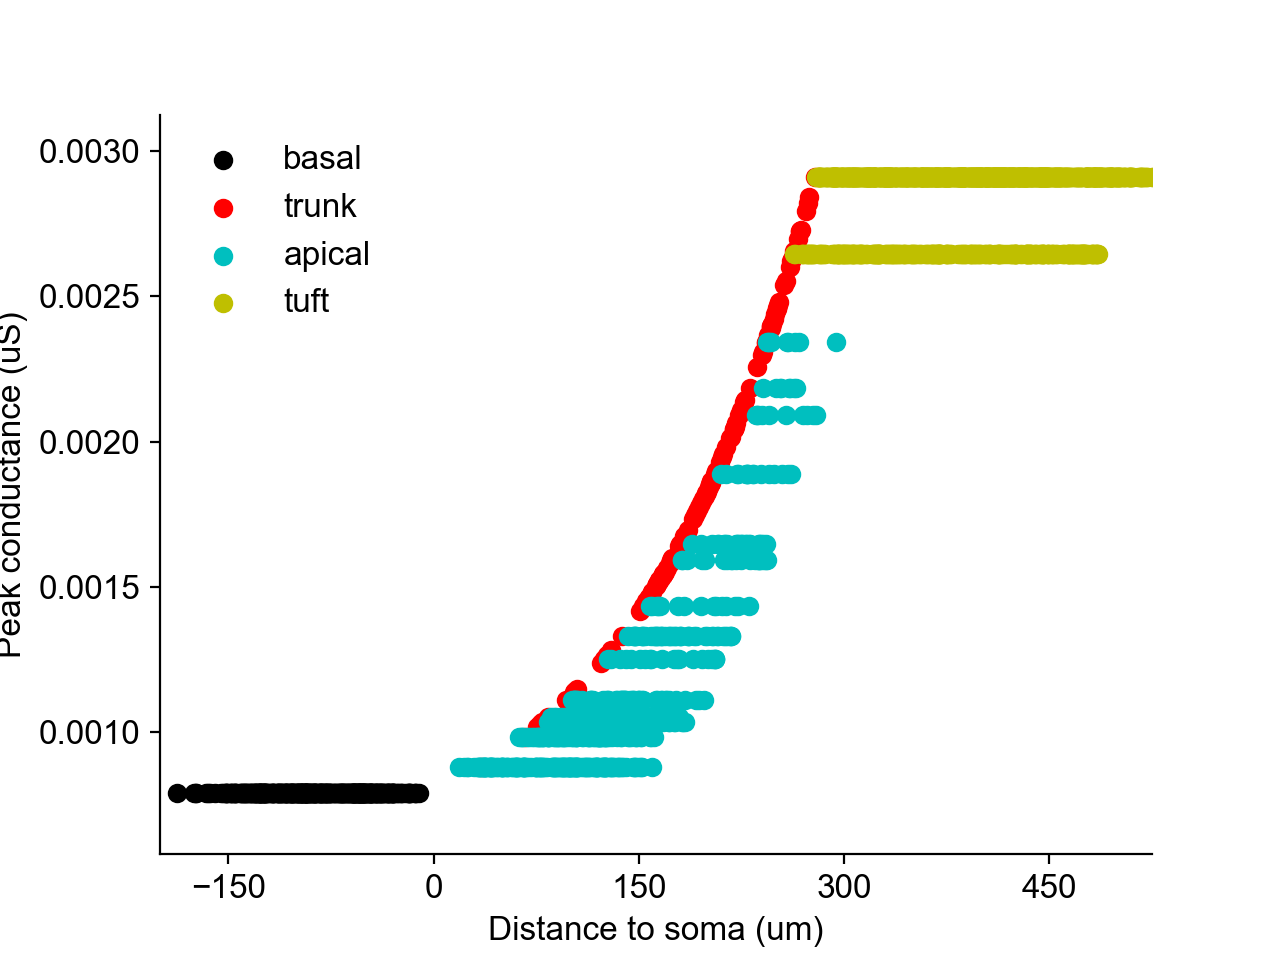

In [15]:
plot_synaptic_param_distribution(cell, AMPAR, 'gmax')

In [ ]:
for syn in trunk.synapses:
    if AMPAR in syn._syn:
        example_exc_syn = syn
        break

In [ ]:
example_exc_syn_mechanism = example_exc_syn.target(AMPAR)

In [ ]:
example_exc_syn_mechanism.gmax

In [ ]:
example_exc_syn.source

In [ ]:
example_exc_syn.netcon(AMPAR)

In [ ]:
sim.modify_stim(amp=0.)

In [ ]:
spike_train = [250.]

In [ ]:
example_exc_syn.source.play(h.Vector(spike_train))
sim.run()
sim.plot()
example_exc_syn.source.play(h.Vector())

In [ ]:
target_firing_rate = 100.  # Hz
random_spike_train = get_inhom_poisson_spike_times([target_firing_rate, target_firing_rate], [250., 350.], dt=sim.dt)
pprint.pprint(random_spike_train)

In [ ]:
example_exc_syn.source.play(h.Vector(random_spike_train))
sim.run()
sim.plot()
example_exc_syn.source.play(h.Vector())

In [16]:
exc_synapse_dict = defaultdict(list)
inh_synapse_dict = defaultdict(list)
for sec_type in cell.nodes:
    for node in cell.nodes[sec_type]:
        if sec_type in ['soma', 'axon']:
            category = 'perisomatic'
        elif sec_type == 'basal':
            category = 'proximal dendritic'
        elif sec_type in ['trunk', 'apical']:
            distance = cell.get_distance_to_node(cell.soma[0], node, 0.)
            if distance <= 200.:
                category = 'proximal dendritic'
            else:
                category = 'distal dendritic'
        elif sec_type == 'tuft':
            category = 'distal dendritic'
        for syn in node.synapses:
            if AMPAR in syn._syn:
                exc_synapse_dict[category].append(syn)
            elif GABAR in syn._syn:
                inh_synapse_dict[category].append(syn)

In [17]:
for category in exc_synapse_dict:
    print('Cell has %i %s excitatory synapses' % (len(exc_synapse_dict[category]), category))
for category in inh_synapse_dict:
    print('Cell has %i %s inhibitory synapses' % (len(inh_synapse_dict[category]), category))

Cell has 985 proximal dendritic excitatory synapses
Cell has 1314 distal dendritic excitatory synapses
Cell has 45 perisomatic inhibitory synapses
Cell has 317 proximal dendritic inhibitory synapses
Cell has 246 distal dendritic inhibitory synapses


In [ ]:
stimulated_exc_syns = []
for category in exc_synapse_dict:
    stimulated_exc_syns.extend(exc_synapse_dict[category])

stimulated_inh_syns = []

In [ ]:
exc_target_firing_rate = 1.  # Hz
exc_population_spike_count = 0
inh_population_spike_count = 0
for syn in stimulated_exc_syns:
    spike_train = get_inhom_poisson_spike_times([exc_target_firing_rate, exc_target_firing_rate], [250., 350.], dt=sim.dt)
    exc_population_spike_count += len(spike_train)
    syn.source.play(h.Vector(spike_train))
exc_population_spike_rate = exc_population_spike_count / (100. / 1000.)  # Hz
inh_population_spike_rate = inh_population_spike_count / (100. / 1000.)  # Hz
print('Input pattern: excitatory rate: %.1f kHz (%i synapses); inhibitory rate: %.1f kHz (%i synapses)' % 
      (exc_population_spike_rate / 1000., len(stimulated_exc_syns), inh_population_spike_rate / 1000., len(stimulated_inh_syns)))

In [ ]:
sim.run()
sim.plot()
for syn in stimulated_exc_syns:
    syn.source.play(h.Vector())
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

In [ ]:
exc_target_firing_rate = 1.8  # Hz
exc_population_spike_count = 0
inh_population_spike_count = 0
for syn in stimulated_exc_syns:
    spike_train = get_inhom_poisson_spike_times([exc_target_firing_rate, exc_target_firing_rate], [250., 350.], dt=sim.dt)
    exc_population_spike_count += len(spike_train)
    syn.source.play(h.Vector(spike_train))
exc_population_spike_rate = exc_population_spike_count / (100. / 1000.)  # Hz
inh_population_spike_rate = inh_population_spike_count / (100. / 1000.)  # Hz
print('Input pattern: excitatory rate: %.1f kHz (%i synapses); inhibitory rate: %.1f kHz (%i synapses)' % 
      (exc_population_spike_rate / 1000., len(stimulated_exc_syns), inh_population_spike_rate / 1000., len(stimulated_inh_syns)))

In [ ]:
sim.run()
sim.plot()
for syn in stimulated_exc_syns:
    syn.source.play(h.Vector())
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

In [ ]:
stimulated_inh_syns = []
for category in inh_synapse_dict:
    stimulated_inh_syns.extend(inh_synapse_dict[category])

In [ ]:
exc_target_firing_rate = 1.8  # Hz
inh_target_firing_rate = 20.  # Hz
exc_population_spike_count = 0
inh_population_spike_count = 0
for syn in stimulated_exc_syns:
    spike_train = get_inhom_poisson_spike_times([exc_target_firing_rate, exc_target_firing_rate], [250., 350.], dt=sim.dt)
    exc_population_spike_count += len(spike_train)
    syn.source.play(h.Vector(spike_train))

for syn in stimulated_inh_syns:
    spike_train = get_inhom_poisson_spike_times([inh_target_firing_rate, inh_target_firing_rate], [250., 350.], dt=sim.dt)
    inh_population_spike_count += len(spike_train)
    syn.source.play(h.Vector(spike_train))

exc_population_spike_rate = exc_population_spike_count / (100. / 1000.)  # Hz
inh_population_spike_rate = inh_population_spike_count / (100. / 1000.)  # Hz
print('Input pattern: excitatory rate: %.1f kHz (%i synapses); inhibitory rate: %.1f kHz (%i synapses)' % 
      (exc_population_spike_rate / 1000., len(stimulated_exc_syns), inh_population_spike_rate / 1000., len(stimulated_inh_syns)))

In [ ]:
sim.run()
sim.plot()
for syn in stimulated_exc_syns:
    syn.source.play(h.Vector())
for syn in stimulated_inh_syns:
    syn.source.play(h.Vector())
spike_output_array = np.array(spike_output_vec)
spike_output_rate = len(np.where((spike_output_array >= 250.) & (spike_output_array <= 350.))[0]) / (100. / 1000.)
print('Output firing rate: %.1f Hz' % spike_output_rate)

Exc input rate vs. output rate

Conditions:
1. All exc synapses + No inh synapses
2. Proximal dendritic exc synapses + No inh synapses
3. Distal dendritic exc synapses + No inh synapses
4. All exc synapses + All inh synapses (20 Hz.)
5. All exc synapses + Perisomatic + inh synapses (20 Hz.)
6. All exc synapses + Proximal dendritic inh synapses (20 Hz.)
7. All exc synapses + Distal dendritic inh synapses (20 Hz.)